# Trading Strategy Development & Testing 

**Goals**

1. Rigorous backtesting framework that avoids **LOOKAHEAD BIAS** and is more sophisticated than just using a simple/elementary train/test split 
2. Develop the following trading strategies: 
   1. Dynamic hedging trading strategies, either or both of: 
      1. Short term mean-reverting signals 
      2. Non-parametric rolling OLS estimation, which will enable me to learn about: 
   2. LOB data 
   3. Risk management 
      1. Stop-loss
      2. Momentum filters 
      3. Managing regime changes/structural breaks/volatility 
3. Test realistically on out-of-sample data and compare to a benchmark 

In [72]:
%load_ext autoreload
%autoreload 2

import lakeapi 
import datetime as dt
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly
import plotly.graph_objects as go 
import numpy as np
from itertools import combinations

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import nolds
pd.set_option('display.max_rows', 100)
from helpers import calculate_rolling_ols_spread_fast
import itertools 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Helper Functions 

In [2]:
def make_prices_by_column(df: pd.DataFrame, value_column = 'str'):
    non_null_df = df[df['symbol'].notna()]
    prices_df = non_null_df.pivot(columns = 'symbol', values = value_column)
    #reindex prices 
    start = prices_df.index.min()
    end = prices_df.index.max()
    complete_index = pd.date_range(start=start, end=end, freq='10s')
    prices_df = prices_df.reindex(complete_index)
    #Reporting 
    num_null_by_symbol = prices_df.isna().sum()
    print(f"Amount of missing data by symbol, {num_null_by_symbol/len(prices_df)}")
    return prices_df

In [3]:
from typing import Literal
def summary_streaks_seconds(series, seconds_per_row = 10, stat: Literal['longest_location', 'describe'] = 'describe'):
    # Create groups of consecutive NaNs
    isnan = series.isna()
    flipped = ~isnan
    streak_counts = flipped.cumsum() #if we are detecting strings of consecutive trues, then flipping it and then doing a cum sum means that the now consecutive falses generate streak of all the same number 
    streak_groups = streak_counts[isnan]
    streak_counts = streak_groups.value_counts() #in terms of number of rows 
    if stat == 'describe': 
        summary = streak_counts.describe(percentiles=[0.25, 0.75, .90, .95, 0.99])
        return summary*seconds_per_row
    elif stat == 'longest_location':
        # Find the longest streak
        longest_streak_id = streak_counts.idxmax()
        # Find where this streak starts (first occurrence of this streak_id)
        longest_streak_indices = streak_groups[streak_groups == longest_streak_id].index
        return longest_streak_indices[0], longest_streak_indices[-1]

In [4]:
import statsmodels.api as sm 
def fit_spread(y: pd.Series, x: pd.Series) -> pd.Series: 
    x_with_constant = sm.add_constant(x)
    results = sm.OLS(y, x_with_constant, missing='drop').fit()  # ← Add this
    b0, b1 = results.params 
    spread = (y - (b0 + b1*x))
    return spread

# Data Processing 

In [5]:
resampled_df = pd.read_parquet('data/level1crypto_raw_origin_times_resampled.parquet')

In [6]:
resampled_df.index.min()
resampled_df.index.max()

Timestamp('2024-11-26 00:00:00')

Timestamp('2025-12-03 23:59:50')

In [6]:
TEST_CUTOFF = dt.datetime(2025, 9, 1)
train_df, test_df = resampled_df[resampled_df.index < TEST_CUTOFF], resampled_df[resampled_df.index >=TEST_CUTOFF]

# Data Processing - Missing Data 

## Test Data 

In [7]:
midprice_test_df = make_prices_by_column(test_df, value_column= 'mid_price')

Amount of missing data by symbol, symbol
BTC-USDT     0.038478
ETH-USDT     0.778727
XRP-USDT     0.000717
BNB-USDT     0.778732
SOL-USDT     0.000725
TRX-USDT     0.000009
DOGE-USDT    0.000719
ADA-USDT     0.000877
XLM-USDT     0.081209
WBTC-USDT    0.053276
dtype: float64


Probably can't do proper out of sample testing on ETH or BNB coins. Also, we are missing XLM data (see training df) so we'll drop that too. 

In [8]:
SECONDS_PER_MINUTE = 60
midprice_test_df.drop(['ETH-USDT', 'BNB-USDT', 'XLM-USDT'], axis=1).apply(summary_streaks_seconds)/SECONDS_PER_MINUTE

symbol,BTC-USDT,XRP-USDT,SOL-USDT,TRX-USDT,DOGE-USDT,ADA-USDT,WBTC-USDT
count,0.500000,0.500000,1.666667,1.166667,0.833333,21.833333,4640.333333
mean,1736.111111,32.333333,9.816667,0.166667,19.466667,0.905852,0.259015
std,2991.451999,55.570026,30.457464,0.000000,43.063003,8.416384,0.191279
min,2.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
25%,9.000000,0.250000,0.166667,0.166667,0.166667,0.166667,0.166667
50%,15.833333,0.333333,0.166667,0.166667,0.166667,0.166667,0.166667
75%,2603.083333,48.416667,0.166667,0.166667,0.333333,0.166667,0.333333
90%,4155.433333,77.266667,9.950000,0.166667,58.033333,0.166667,0.500000
95%,4672.883333,86.883333,53.225000,0.166667,77.266667,0.166667,0.666667
99%,5086.843333,94.576667,87.845000,0.166667,92.653333,0.333333,1.000000


Note this shouldn't be prohibitive - we have 3 months of 10 second data so we will just have to be careful how we do out of sample testing. 

# Data Processing - Training Data Only 

Note that the majority of our data problems are technically due to problems with the *test* dataset. 

In [9]:
train_midprice_df = make_prices_by_column(train_df, value_column= 'mid_price')

Amount of missing data by symbol, symbol
BTC-USDT     0.000007
ETH-USDT     0.002596
XRP-USDT     0.017218
BNB-USDT     0.002801
SOL-USDT     0.017795
TRX-USDT     0.000723
DOGE-USDT    0.017218
ADA-USDT     0.018124
WBTC-USDT    0.041845
dtype: float64


In [10]:
train_midprice_df.drop(['ETH-USDT', 'BNB-USDT'], axis=1).apply(summary_streaks_seconds)/SECONDS_PER_MINUTE

symbol,BTC-USDT,XRP-USDT,SOL-USDT,TRX-USDT,DOGE-USDT,ADA-USDT,WBTC-USDT
count,0.333333,2.833333,225.000000,17.500000,2.500000,322.666667,11290.166667
mean,1.416667,406.911765,5.295679,2.766667,461.155556,3.761019,0.248176
std,1.296362,968.360040,114.806483,7.009936,1022.195964,95.887112,0.338282
min,0.500000,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
25%,0.958333,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
50%,1.416667,0.166667,0.166667,0.333333,0.333333,0.166667,0.166667
75%,1.875000,6.666667,0.166667,0.833333,267.083333,0.166667,0.333333
90%,2.150000,1310.700000,0.166667,12.333333,1315.966667,0.333333,0.500000
95%,2.241667,1811.933333,0.166667,12.500000,2054.650000,0.333333,0.500000
99%,2.315000,3365.320000,0.333333,12.660000,3413.863333,0.500000,1.000000


Coins that are ok, with just some massive outliers: 

- BTC 
- SOL 
- TRX
- ADA 
- WBTC 

Where do these outliers happen/long streaks happen? 

In [14]:
train_midprice_df.drop(['ETH-USDT', 'BNB-USDT'], axis=1).apply(lambda x: summary_streaks_seconds(x, stat = 'longest_location'))

symbol,BTC-USDT,XRP-USDT,SOL-USDT,TRX-USDT,DOGE-USDT,ADA-USDT,WBTC-USDT
0,2025-08-23 06:06:20,2025-03-04 00:00:00,2025-03-04 00:00:00,2025-04-09 01:22:10,2025-03-04 00:00:00,2025-03-04 00:00:00,2025-04-09 01:22:10
1,2025-08-23 06:08:30,2025-03-06 14:33:30,2025-03-06 14:33:30,2025-04-09 02:21:10,2025-03-06 14:33:30,2025-03-06 14:33:30,2025-04-09 02:21:10


Note that these massive "gaps" occur around the same time - i.e. the 2025-03-04 zone, so the concern that maybe front-filling values might be "messing" up/giving misleading comovement signals is minimised. 

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

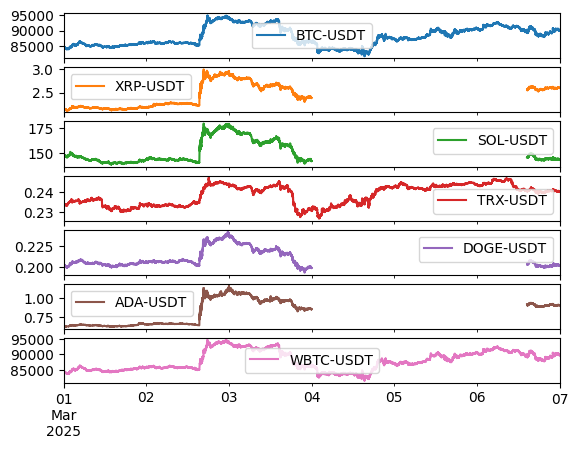

In [71]:
train_midprice_df.drop(['ETH-USDT', 'BNB-USDT'], axis=1).loc[dt.date(2025, 3, 1):dt.date(2025, 3, 7)].plot(subplots=True)

# Rolling Estimation: ADA-USDT, SOL-USDT 

See other notebook for full justification of how we go about selecting pairs. Note the complication of these "chunks" of missing data but we will come back to that. 

The basic problem: even if some series *were* cointegratd, most likely that they exhibit very weak levels of long-term mean reversion. If there is to be a mean-reversion based pairs trading strategy, it will be based on trading short-term mean-reversion patterns around a moving equilibrium. 

In [11]:
train_midprice_df = train_midprice_df.drop(['ETH-USDT', 'BNB-USDT'], axis=1)

In [77]:
train_midprice_df[['ADA-USDT', 'SOL-USDT']].corr()

symbol,ADA-USDT,SOL-USDT
symbol,,
ADA-USDT,1.000000,0.845929
SOL-USDT,0.845929,1.000000


In [120]:
from itertools import permutations

PAIRS = list(permutations(train_midprice_df.columns, 2))
static_spreads_df = pd.DataFrame({
    f"{pair[0]}-{pair[1]}": fit_spread(x=train_midprice_df[pair[0]], y=train_midprice_df[pair[1]]) 
    for pair in PAIRS
})

hurst_ols_df = pd.DataFrame({
    col: nolds.mfhurst_b(static_spreads_df[col], qvals=[1, 2]) 
    for col in static_spreads_df
}, index=['q=1', 'q=2']).T
hurst_ols_df.sort_values(['q=1', 'q=2']).head(n=5)

,q=1,q=2
BTC-USDT-WBTC-USDT,0.198222,0.198901
WBTC-USDT-BTC-USDT,0.198408,0.199066
ADA-USDT-DOGE-USDT,0.475137,0.479084
DOGE-USDT-ADA-USDT,0.479913,0.481840
SOL-USDT-ADA-USDT,0.486822,0.487590


## Implementation 

Question - is there sufficient mean reversion to make a mean-reverting trading strategy profitable? 

I am interested in evaluating, **on the training data**, how a rolling OLS/Bol band trading strategy performs compares to say, a benchmark buy/hold strategy. 

Simplest backtesting approach: 
1. Optimise OLS on the first 6 months of data, then draw conclusions on the next 3 months of data 

More sophisticated: 
1. Walk-forward testing 
   1. Do out of sample testing in a "walk-forward" manner, then average across the out of sample periods 

I have a VERY simple goal: 
- Use the training data to evaluate whether trading on short-term mean reversion patterns is more profitable than a benchmark buy/hold strategy. 
- At the same time, I need to choose the parameters in the first place 

<Axes: >

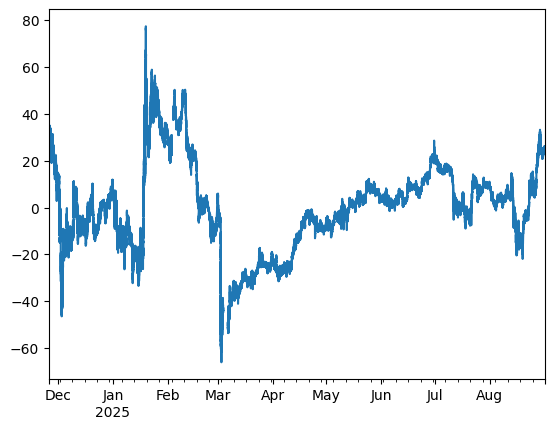

In [92]:
static_spreads_df['ADA-USDT-SOL-USDT'].plot()

# Research Question 

Is a dynamic hedging strategy profitable on THIS specific cryptocurrency pair compared to a benchmark strategy? Why or why not? If so, what is the BEST PERFORMER OUT OF THESE dynamic hedging strategies? 

This question has 3 components: 
1. Justify WHAT dynamic spread is the BEST pricing signal for a mean reversion strategy 
2. Translate this pricing signal into a trading STRATEGY and **justify** your parameter choices 
   1. Also, incorporate LOB data 
3. Perform a backtest that is as **REALISTIC** as possible/needed 
   1. Write down any/all assumptions that might impact the validity of our results  

## Pass 1: Is there any rolling OLS/Bol band trading strategy that we can use to make money? 

Methodology: 
Split up training data into two separate datasets: 
1. Training dataset, which we will use to: 
      - Choose a lookback period/optimise pricing signal 
      - For EACH candidate pricing signal, use walk-forward CV to select the BEST possible trading parameters GIVEN that particular pricing signal 
2. Validation dataset 
   1. Compare the performance of each finalised strategy and compare to a simple benchmark strategy. 

#TODO - If we are interested, once we've done this/systematized the approach we can consider trying to incorporate some kidn of k-fold cross-validation on step 2, or do some kind of statistical/significance testing. 

We have a large chunk of missing data of around 3 days for both ADA and SOL that occurs right in the middle of the training dataset, so to make things easier for us let's split up our training dataset into a training/validation part around this cutoff. 

In [12]:
pairs_df = train_df[train_df['symbol'].isin(['ADA-USDT', 'SOL-USDT'])].pivot(columns = 'symbol', values = ['bid_0_price', 'ask_0_price', 'bid_0_size', 'ask_0_size', 'mid_price'])
CUTOFF_TRAINING = dt.datetime(2025, 4, 3)
CUTOFF_VALIDATION = dt.datetime(2025, 4, 5)
pairs_training_df = pairs_df[pairs_df.index<=CUTOFF_TRAINING]
pairs_validation_df = pairs_df[pairs_df.index >=CUTOFF_VALIDATION]

### Pricing Signal 

In [13]:
DAYS_IN_WEEK = 7 
HOURS_IN_DAYS = 24
MINUTES_PER_HOUR = 60 
TICKS_PER_MINUTE = 6

In [14]:
pairs_training_df

bid_0_price          ask_0_price          bid_0_size  \
symbol                 SOL-USDT ADA-USDT    SOL-USDT ADA-USDT   SOL-USDT   
origin_time                                                                
2024-11-26 00:00:00      233.87   0.9426      233.88   0.9427     50.141   
2024-11-26 00:00:10      234.33      NaN      234.34      NaN      0.023   
2024-11-26 00:00:20      234.21   0.9434      234.22   0.9435    102.100   
2024-11-26 00:00:30      234.14   0.9440      234.15   0.9441     51.115   
2024-11-26 00:00:50      233.90   0.9426      233.91   0.9427     57.078   
...                         ...      ...         ...      ...        ...   
2025-04-02 23:59:20      117.25   0.6391      117.26   0.6392    251.717   
2025-04-02 23:59:30      117.39   0.6399      117.40   0.6400    514.167   
2025-04-02 23:59:40      117.44   0.6400      117.45   0.6401      0.360   
2025-04-02 23:59:50      117.40   0.6400      117.41   0.6401    133.969   
2025-04-03 00:00:00      117.19   0.6400      117.20   0.6401    377.412   

                             ask_0_size          mid_price           
symbol              ADA-USDT   SOL-USDT ADA-USDT  SOL-USDT ADA-USDT  
origin_time                                                          
2024-11-26 00:00:00   4115.9     74.033   3701.5   233.875  0.94265  
2024-11-26 00:00:10      NaN     66.220      NaN   234.335      NaN  
2024-11-26 00:00:20   4616.5     22.076  10869.4   234.215  0.94345  
2024-11-26 00:00:30   1610.6     44.458   4015.1   234.145  0.94405  
2024-11-26 00:00:50   2290.9     60.073   1464.0   233.905  0.94265  
...                      ...        ...      ...       ...      ...  
2025-04-02 23:59:20  16096.9    123.271   5086.3   117.255  0.63915  
2025-04-02 23:59:30  20870.1     62.678  18947.8   117.395  0.63995  
2025-04-02 23:59:40   4550.9    341.466  16057.5   117.445  0.64005  
2025-04-02 23:59:50  25571.9    214.180   7977.2   117.405  0.64005  
2025-04-03 00:00:00  20248.4     44.627   9160.5   117.195  0.64005  

[1064353 rows x 10 columns]

In [ ]:
#check for instances of missing data 
pairs_training_df.isna().sum()/len(pairs_training_df)

             symbol  
bid_0_price  SOL-USDT    0.001182
             ADA-USDT    0.001895
ask_0_price  SOL-USDT    0.001182
             ADA-USDT    0.001895
bid_0_size   SOL-USDT    0.001182
             ADA-USDT    0.001895
ask_0_size   SOL-USDT    0.001182
             ADA-USDT    0.001895
mid_price    SOL-USDT    0.001182
             ADA-USDT    0.001895
dtype: float64

Since we are not missing any major chunks of data, it's safe to evaluate potential pricing signals on **front-filled** pricing series. 

Vidyamurty suggests using the VWAP price to estimate pricing signal, but for simplicity we will just use the top-level bid/ask spread mid-price for now. 

In [37]:
pairs_training_df.apply(summary_streaks_seconds)/SECONDS_PER_MINUTE

bid_0_price             ask_0_price              bid_0_size  \
symbol    SOL-USDT    ADA-USDT    SOL-USDT    ADA-USDT    SOL-USDT   
count   201.500000  297.166667  201.500000  297.166667  201.500000   
mean      0.173422    0.188540    0.173422    0.188540    0.173422   
std       0.035567    0.070769    0.035567    0.070769    0.035567   
min       0.166667    0.166667    0.166667    0.166667    0.166667   
25%       0.166667    0.166667    0.166667    0.166667    0.166667   
50%       0.166667    0.166667    0.166667    0.166667    0.166667   
75%       0.166667    0.166667    0.166667    0.166667    0.166667   
90%       0.166667    0.333333    0.166667    0.333333    0.166667   
95%       0.166667    0.333333    0.166667    0.333333    0.166667   
99%       0.333333    0.500000    0.333333    0.500000    0.333333   
max       0.500000    1.166667    0.500000    1.166667    0.500000   

                    ask_0_size               mid_price              
symbol    ADA-USDT    SOL-USDT    ADA-USDT    SOL-USDT    ADA-USDT  
count   297.166667  201.500000  297.166667  201.500000  297.166667  
mean      0.188540    0.173422    0.188540    0.173422    0.188540  
std       0.070769    0.035567    0.070769    0.035567    0.070769  
min       0.166667    0.166667    0.166667    0.166667    0.166667  
25%       0.166667    0.166667    0.166667    0.166667    0.166667  
50%       0.166667    0.166667    0.166667    0.166667    0.166667  
75%       0.166667    0.166667    0.166667    0.166667    0.166667  
90%       0.333333    0.166667    0.333333    0.166667    0.333333  
95%       0.333333    0.166667    0.333333    0.166667    0.333333  
99%       0.500000    0.333333    0.500000    0.333333    0.500000  
max       1.166667    0.500000    1.166667    0.500000    1.166667

In [ ]:
signal_df = pairs_training_df.ffill()

array([<Axes: xlabel='origin_time'>, <Axes: xlabel='origin_time'>],
      dtype=object)

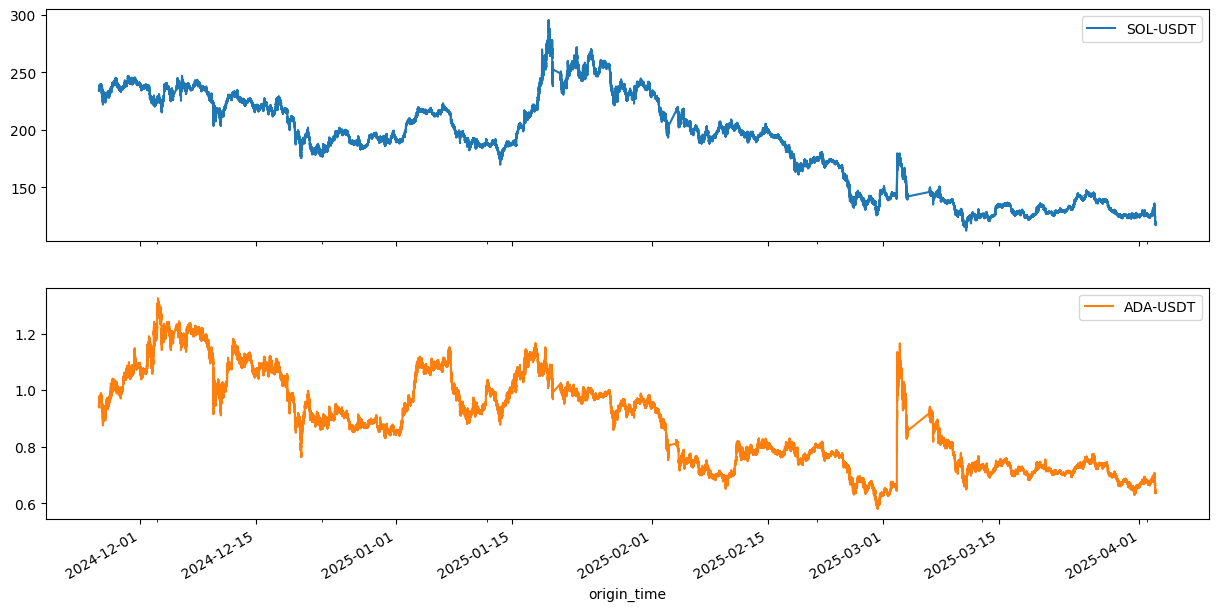

In [48]:
signal_df['mid_price'].plot(subplots=True, figsize = (15, 7.5))

Note that ADA and SOL have extremely different value ranges - we should take note of this in our trading implementation. 

### EDA - Data anomalies 

TODO - What is this spike around 2025-03? Investigate it. 

In [16]:
DAYS_IN_WEEK = 7 
HOURS_IN_DAYS = 24
MINUTES_PER_HOUR = 60 
TICKS_PER_MINUTE = 6

BETA_LOOKBACK_GRID = {
    'hour': 1*MINUTES_PER_HOUR*TICKS_PER_MINUTE,
    'day': 1*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE, # 1 day, 
    'week': 7*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE,  # 7 days, 
    'month': 30*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE, #30 days (1 month)
}

In [17]:
midprice_df = signal_df['mid_price']
midprice_df

symbol,SOL-USDT,ADA-USDT
origin_time,,
2024-11-26 00:00:00,233.875,0.94265
2024-11-26 00:00:10,234.335,0.94265
2024-11-26 00:00:20,234.215,0.94345
2024-11-26 00:00:30,234.145,0.94405
2024-11-26 00:00:50,233.905,0.94265
...,...,...
2025-04-02 23:59:20,117.255,0.63915
2025-04-02 23:59:30,117.395,0.63995
2025-04-02 23:59:40,117.445,0.64005


In [18]:
ols_lookback = pd.concat(
    {
        lookback: calculate_rolling_ols_spread_fast(midprice_df, 'ADA-USDT', 'SOL-USDT', window=window)
        for lookback, window in BETA_LOOKBACK_GRID.items()
    },
    axis=1
)

# Swap levels so alpha/beta/spread is top level
ols_lookback = ols_lookback.swaplevel(axis=1)
ols_lookback = ols_lookback.sort_index(axis=1)

In [19]:
spreads_by_lookback = ols_lookback['spread']

array([<Axes: xlabel='origin_time'>, <Axes: xlabel='origin_time'>,
       <Axes: xlabel='origin_time'>, <Axes: xlabel='origin_time'>],
      dtype=object)

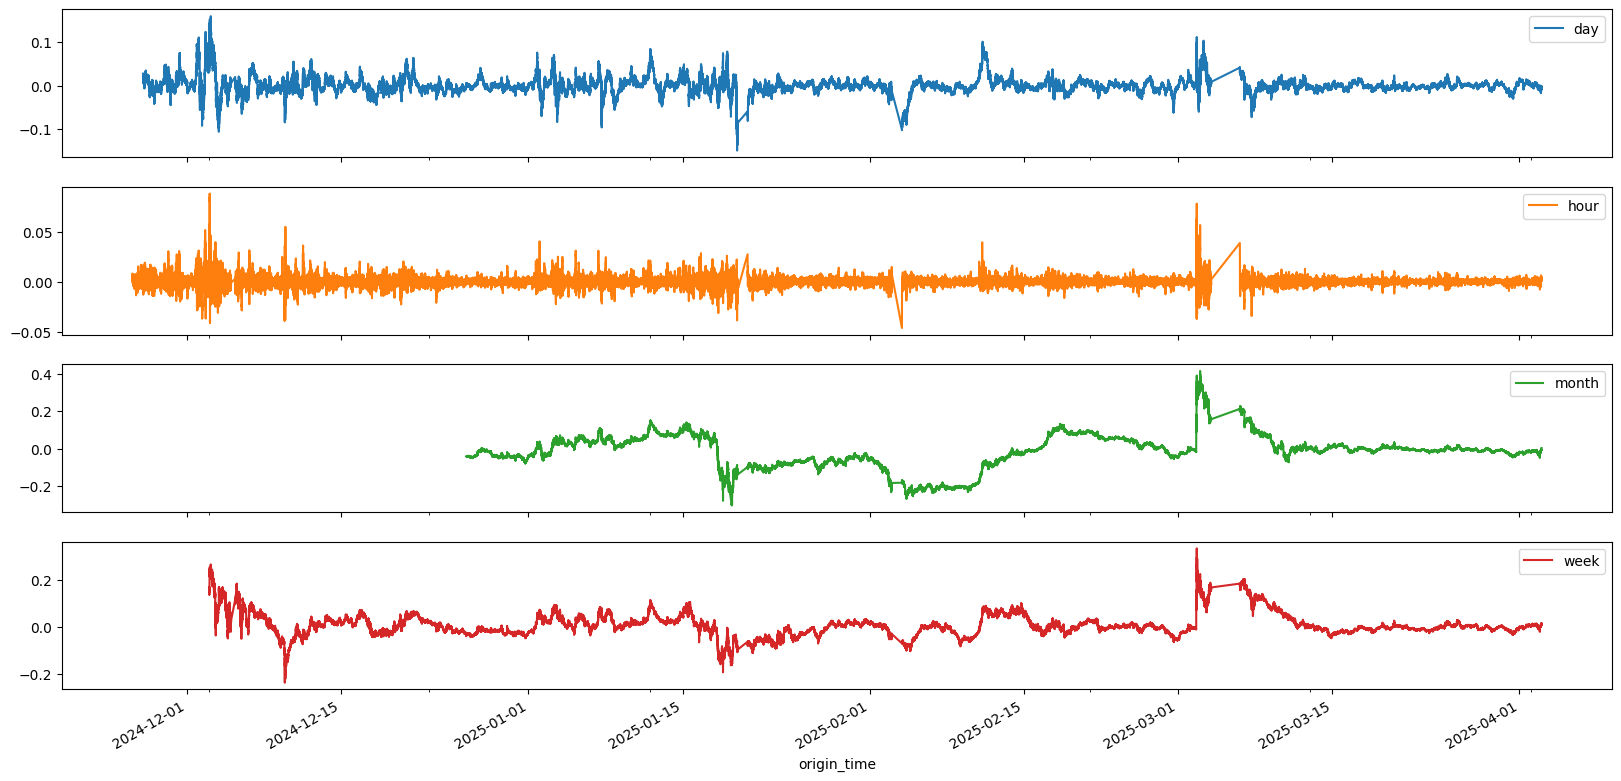

In [82]:
spreads_by_lookback.plot(subplots=True, figsize = (20, 10))

In [83]:
from statsmodels.tsa.stattools import coint, adfuller, kpss

In [89]:
#Test 2 - Are any of them stationary? Use ADF test and rank by significance 
for lb in spreads_by_lookback.columns: 
    #to save time, subsample for every 1 minute
    price_series = spreads_by_lookback[lb].asfreq('1min').dropna()
    print(f"ADF test for {lb} lookback")
    adfuller(price_series)
    print(f"KPSS test for {lb} lookback")
    kpss(price_series)

ADF test for day lookback


(np.float64(-13.888150038616716),
 np.float64(6.036455105992987e-26),
 77,
 175869,
 {'1%': np.float64(-3.430387183332188),
  '5%': np.float64(-2.861556434528405),
  '10%': np.float64(-2.566778747510773)},
 np.float64(-1816596.6016509074))

KPSS test for day lookback


(np.float64(0.38590435437563514),
 np.float64(0.08323088173464002),
 239,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

ADF test for hour lookback


(np.float64(-42.961525975608765),
 0.0,
 77,
 177251,
 {'1%': np.float64(-3.4303868934150126),
  '5%': np.float64(-2.861556306389743),
  '10%': np.float64(-2.5667786793070144)},
 np.float64(-1846924.478837781))

KPSS test for hour lookback


/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_31114/2506726782.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(price_series)


(np.float64(0.1351486118658621),
 np.float64(0.1),
 215,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

ADF test for month lookback


(np.float64(-2.9707857132986835),
 np.float64(0.03771418805650019),
 73,
 134116,
 {'1%': np.float64(-3.4303987594706427),
  '5%': np.float64(-2.8615615509825223),
  '10%': np.float64(-2.566781470823351)},
 np.float64(-1408961.6135876547))

KPSS test for month lookback


/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_31114/2506726782.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(price_series)


(np.float64(5.222191646031988),
 np.float64(0.01),
 209,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

ADF test for week lookback


(np.float64(-6.83881493330472),
 np.float64(1.8133011974249546e-09),
 77,
 167231,
 {'1%': np.float64(-3.4303891039961427),
  '5%': np.float64(-2.8615572834302236),
  '10%': np.float64(-2.5667791993517777)},
 np.float64(-1717899.070097357))

KPSS test for week lookback


/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_31114/2506726782.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(price_series)


(np.float64(1.247255024614405),
 np.float64(0.01),
 235,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Results: 
- ADFuller: 
  - REJECT null hypothesis of non-stationarity for day, hour, and week at <1% level of significance 
  - REJECT null hypothesis of non-stationarity for month at 5% level of significance 
- KPSS: 
  - cannot reject null hypothesis of non-stationarity at 5% level for: 
    - day/hour 
  - REJECT null hypothesis of non-stationarity at 1% level for (i.e. is STATIONARY)
    - Week 
    - Month 

In [125]:
#Test 3 - Comparison to cointegration/static spread
# see hurst exponent 

static_spread = static_spreads_df['ADA-USDT-SOL-USDT']
results_static = zero_crossings_with_buffer(static_spread)
results_static[1].quantile([0.5, 0.99])

0.50     67385.000000
0.99    165943.126667
dtype: float64

In [91]:
#Test 4 - Hurst exponent - is this... legal? Just use as a heuristic, anyway 

hurst_df = pd.DataFrame({
    col: nolds.mfhurst_b(spreads_by_lookback[col], qvals=[1, 2]) 
    for col in spreads_by_lookback
}, index=['q=1', 'q=2']).T

In [92]:
hurst_df.sort_values(['q=1', 'q=2'])

,q=1,q=2
hour,0.231277,0.216177
day,0.437307,0.418391
week,0.483315,0.464645
month,0.508110,0.510839


- From HE perspecitvely, only hour/day OLS are a clear improvement on static OLS spread 

TODO - question mark about what exactly zero-crossing capture. 

In [ ]:
#Test 5 - Empirical - Mean reversion crossing times 
#Try to estimate frequency of mean reversion crossings 

from helpers import zero_crossings, zero_crossings_with_buffer, zero_crossings_percentile

In [114]:
results_buffer_hour = zero_crossings_with_buffer(spreads_by_lookback['hour'])
results_buffer_day = zero_crossings_with_buffer(spreads_by_lookback['day'])
results_buffer_week = zero_crossings_with_buffer(spreads_by_lookback['week'])
results_buffer_month = zero_crossings_with_buffer(spreads_by_lookback['month'])

In [112]:
results_buffer_hour[1].quantile([0.5, 0.99])

0.50     39.5
0.99    726.4
Name: origin_time, dtype: float64

In [113]:
results_buffer_day[1].quantile([0.5, 0.99])

0.50      948.750000
0.99    10657.783333
Name: origin_time, dtype: float64

In [115]:
results_buffer_week[1].quantile([0.5, 0.99])

0.50     8587.583333
0.99    34959.191667
Name: origin_time, dtype: float64

In [116]:
results_buffer_month[1].quantile([0.5, 0.99])

0.50    43114.5
0.99    43114.5
Name: origin_time, dtype: float64

### Statistical Significance of Results 

In [161]:
def zero_crossings_quantile(spread): 
    _, interarrivals, _ = zero_crossings_with_buffer(spread)
    return interarrivals.quantile([0.5, 0.99])

def hurst_exponent(spread):
    return nolds.mfhurst_b(spread, qvals = [1]) 

In [159]:
from arch.bootstrap import CircularBlockBootstrap
def bootstrap_confidence_interval(spread, metric_func, n_bootstrap=1000, 
                                 block_size=50, confidence=0.95):
    """
    Calculate bootstrap CI for scalar OR vector-valued metrics
    """
    # Observed metric
    observed = metric_func(spread)
    is_scalar = np.isscalar(observed) or (isinstance(observed, np.ndarray) and observed.size == 1)
    
    # Bootstrap distribution
    bootstrap_metrics = []
    bs = CircularBlockBootstrap(block_size, spread.values)
    
    for data in bs.bootstrap(n_bootstrap):
        boot_spread = pd.Series(data[0][0], index=spread.index)
        bootstrap_metrics.append(metric_func(boot_spread))
    
    # Convert to array (handles both scalar and vector)
    bootstrap_metrics = np.array(bootstrap_metrics)
    
    if is_scalar:
        # Original scalar logic
        alpha = 1 - confidence
        lower = np.percentile(bootstrap_metrics, 100 * alpha / 2)
        upper = np.percentile(bootstrap_metrics, 100 * (1 - alpha / 2))
        
        return {
            'observed': observed,
            'ci_lower': lower,
            'ci_upper': upper,
            'bootstrap_mean': bootstrap_metrics.mean(),
            'bootstrap_std': bootstrap_metrics.std()
        }
    else:
        # Vector-valued: CI for each element
        alpha = 1 - confidence
        lower = np.percentile(bootstrap_metrics, 100 * alpha / 2, axis=0)
        upper = np.percentile(bootstrap_metrics, 100 * (1 - alpha / 2), axis=0)
        
        return {
            'observed': observed,
            'ci_lower': lower,
            'ci_upper': upper,
            'bootstrap_mean': bootstrap_metrics.mean(axis=0),
            'bootstrap_std': bootstrap_metrics.std(axis=0)
        }

In [135]:
len(midprice_df)

1064353

In [154]:
spreads_by_lookback['week']

origin_time
2024-11-26 00:00:00         NaN
2024-11-26 00:00:10         NaN
2024-11-26 00:00:20         NaN
2024-11-26 00:00:30         NaN
2024-11-26 00:00:50         NaN
                         ...   
2025-04-02 23:59:20    0.012902
2025-04-02 23:59:30    0.012966
2025-04-02 23:59:40    0.012803
2025-04-02 23:59:50    0.013012
2025-04-03 00:00:00    0.014112
Name: week, Length: 1064353, dtype: float64

In [155]:
#estimate block size 

from statsmodels.tsa.stattools import acf
def quick_block_size(spread):
    """Find the first place autocorrelation drops to ~0"""
    # Get ACF up to reasonable lag
    spread = spread.dropna()
    max_lag = len(spread) // 4
    acf_values = acf(spread, nlags=max_lag, fft=True)
    
    # Block size = first lag where ACF < 0.1
    block_size = np.argmax(acf_values < 0.1)
    
    # Default to cube root if ACF doesn't decay
    if block_size == 0:
        block_size = int(len(spread) ** (1/3))
    
    return max(block_size, 10)  # Minimum 10

In [ ]:
# Need - block size > correlation length in the data 
pd.Series({
    col: quick_block_size(spreads_by_lookback[col]) for col in spreads_by_lookback.columns
})

day       4014
hour       202
month    77623
week     28794
dtype: int64

In [167]:
quick_block_size(static_spread)

np.int64(188965)

In [168]:
bootstrap_confidence_interval(static_spread, metric_func = hurst_exponent, n_bootstrap = 1_000, block_size = 190_000, confidence = 0.95)

{'observed': array([0.48785862]),
 'ci_lower': np.float64(0.49373275759664237),
 'ci_upper': np.float64(0.5253159046347696),
 'bootstrap_mean': np.float64(0.509804106004596),
 'bootstrap_std': np.float64(0.008244934233140239)}

In [ ]:
bootstrap_confidence_interval(spreads_by_lookback['hour'], metric_func = hurst_exponent, n_bootstrap = 1_000, block_size = 200, confidence = 0.95)

{'observed': array([0.23127722]),
 'ci_lower': np.float64(0.21866831614018467),
 'ci_upper': np.float64(0.22370302710464635),
 'bootstrap_mean': np.float64(0.22107529774384627),
 'bootstrap_std': np.float64(0.0012458540417537524)}

KeyboardInterrupt: 

In [165]:
bootstrap_confidence_interval(spreads_by_lookback['day'], metric_func = hurst_exponent, n_bootstrap = 1_000, block_size = 4100, confidence = 0.95)

{'observed': array([0.43730652]),
 'ci_lower': np.float64(0.432365757874079),
 'ci_upper': np.float64(0.45607401948240994),
 'bootstrap_mean': np.float64(0.4446231296047201),
 'bootstrap_std': np.float64(0.006098311540418413)}

In [166]:
bootstrap_confidence_interval(spreads_by_lookback['week'], metric_func = hurst_exponent, n_bootstrap = 1_000, block_size = 30_000, confidence = 0.95)

{'observed': array([0.48331537]),
 'ci_lower': np.float64(0.49033479945936),
 'ci_upper': np.float64(0.5204239128606067),
 'bootstrap_mean': np.float64(0.505583320451714),
 'bootstrap_std': np.float64(0.007765073243752981)}

#TODO - Using boostrap measures - only hour and day are statistically more mean reverting than a random walk series. Let's see if we can get a more precise measure by increasing number of bootstraps. 
#TODO - why doesn't ADF capture variance aspect of weak stationarity? 

## Pricing Signal - Why do we use rolling z-score? 

Let's focus on hour and day since these are tangibly "better" than using a static spread, giving increased degree/speed of mean reversion. 

In order to generate a trading signal from our candidate price series we will focus first on the simplest kind, which is a Bollinger band based strategy from a rolling z-score calculation. 

Some textbooks/approaches just directly optimise/backtest the lookback period alongside entry/exit thresholds, but in my opinion this introduces a lot of arbitrariness/the risk of overfitting. 
Many papers/github tutorials also do not truly explain the point of having a rolling lookback in the first place. Obviously there is the computational constraint - when we are trading in real time we only have information up to the present. However, in order to properly select the best rolling lookback we really need to understand what SPECIFIC FUNCTION it serves so we can then optimise for that.

It's important to think about **WHAT** the point is of a rolling lookback approach in the first place. Unlike time-series approaches for mean-reversion based pairs trading that seek to **directly model** the candidate spread series and generate *predictions* of future moves, the rolling z-score is not a predictive approach, but rather a classification one. 

Some initial ideas: 

Alignment
- When the z_score is HIGH, is the spread series actually abnormal? 
- When the z_score is LOW, is the spread series actually within the mean? 

Classification
- When the z_score is HIGH, does the spread series revert back to the mean 

In [169]:
# Case 1 - Stable, global mean with heteroskedasticity 

import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def simulate_mean_reverting_spread_with_volatility_regime(
    start_date='2024-01-01',
    n_days=90,
    freq_seconds=10,
    mean=10.0,
    phi=0.95,  # AR(1) coefficient (high = slow reversion)
    base_vol=0.5,
    high_vol_multiplier=3.0,
    high_vol_hours=(16, 18)  # 4pm-6pm
):
    """
    Simulate mean-reverting spread with time-of-day volatility
    
    Parameters
    ----------
    start_date : str
        Start date
    n_days : int
        Number of days
    freq_seconds : int
        Tick frequency in seconds
    mean : float
        Long-run mean
    phi : float
        AR(1) coefficient (closer to 1 = slower mean reversion)
    base_vol : float
        Base volatility
    high_vol_multiplier : float
        Multiplier for high volatility periods
    high_vol_hours : tuple
        (start_hour, end_hour) for high volatility
        
    Returns
    -------
    pd.Series with DatetimeIndex
    """
    # Generate timestamps
    periods_per_day = (24 * 60 * 60) // freq_seconds
    total_periods = n_days * periods_per_day
    
    timestamps = pd.date_range(
        start=start_date,
        periods=total_periods,
        freq=f'{freq_seconds}S'
    )
    
    # Initialize
    spread = np.zeros(total_periods)
    spread[0] = mean
    
    # Generate AR(1) with time-varying volatility
    for t in range(1, total_periods):
        # Get hour of day
        hour = timestamps[t].hour
        
        # Volatility regime
        if high_vol_hours[0] <= hour < high_vol_hours[1]:
            vol = base_vol * high_vol_multiplier
        else:
            vol = base_vol
        
        # AR(1) dynamics: y_t = mean + phi*(y_{t-1} - mean) + vol*epsilon
        epsilon = np.random.normal(0, 1)
        spread[t] = mean + phi * (spread[t-1] - mean) + vol * epsilon
    
    return pd.Series(spread, index=timestamps, name='spread')

In [178]:
np.random.seed(42)
spread = simulate_mean_reverting_spread_with_volatility_regime(
    start_date='2024-01-01',
    n_days=10,
    freq_seconds=3600, # hourly 
    mean=10.0,
    phi=0.5,  
    base_vol=0.75,
    high_vol_multiplier=3.0,
    high_vol_hours=(16, 18)
)

/var/folders/ym/_trdyjp50zv02lvg3nv9km7h0000gn/T/ipykernel_31114/3598121767.py:45: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(


Text(0, 0.5, 'Spread')

Text(0.5, 1.0, 'Simulated Mean-Reverting Spread')

Text(0, 0.5, 'Spread')

Text(0.5, 0, 'Time')

Text(0.5, 1.0, 'Spread with High Volatility Periods Highlighted')

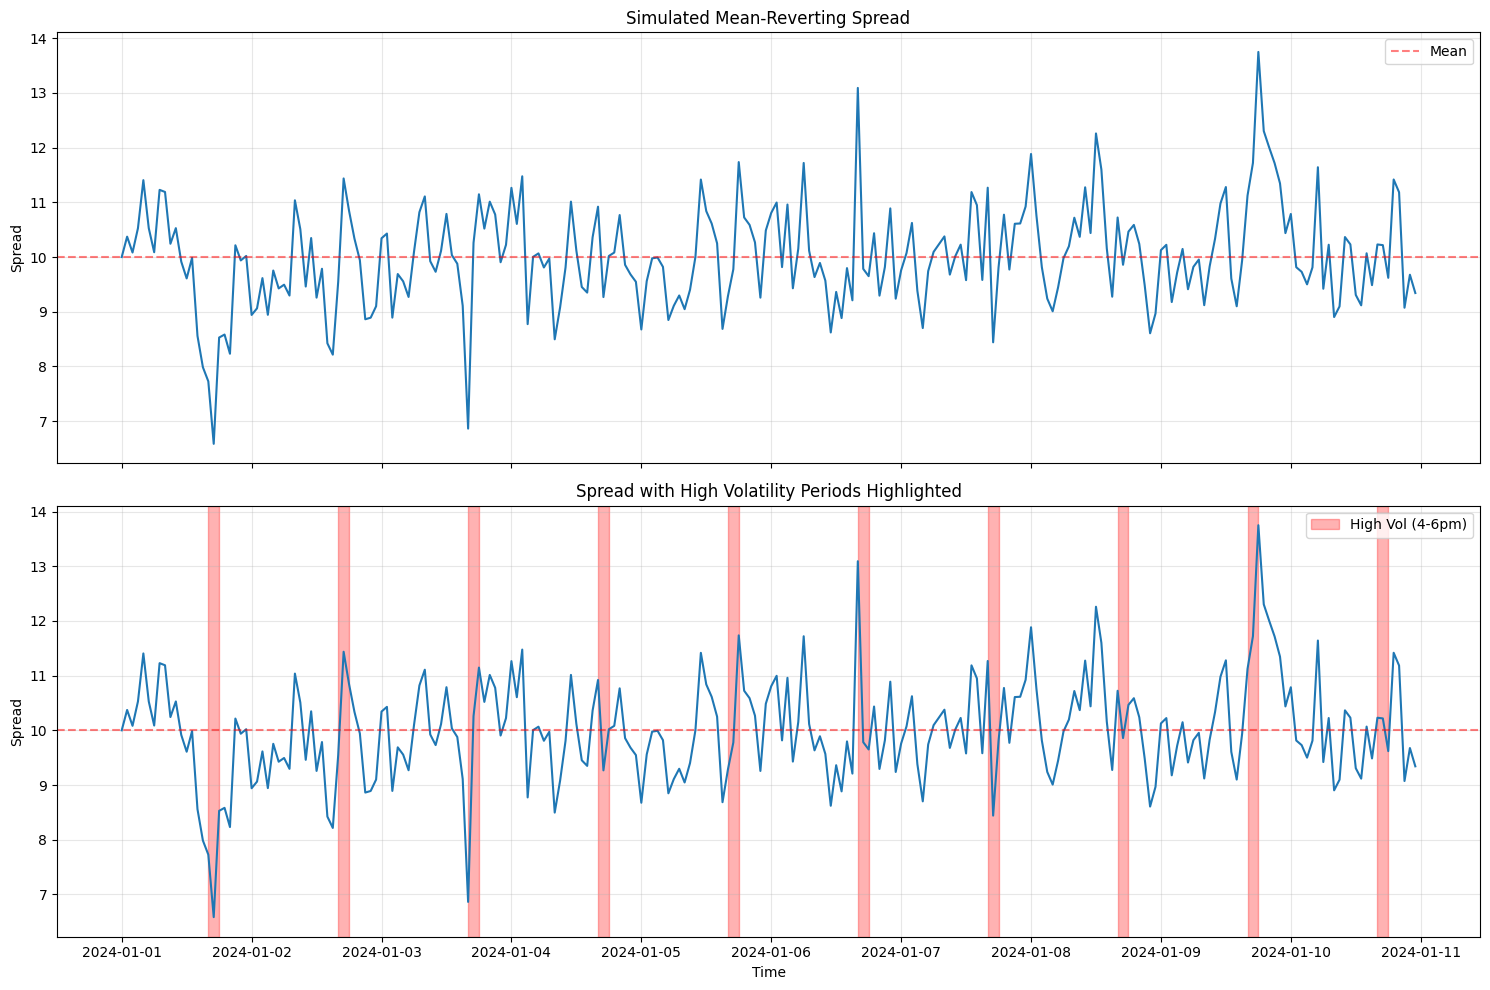

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot 1: Spread
axes[0].plot(spread)
axes[0].axhline(y=10, color='r', linestyle='--', alpha=0.5, label='Mean')
axes[0].set_ylabel('Spread')
axes[0].set_title('Simulated Mean-Reverting Spread')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Highlight high volatility periods
axes[1].plot(spread)
axes[1].axhline(y=10, color='r', linestyle='--', alpha=0.5)

# Shade high volatility hours (4pm-6pm)
for day in spread.resample('D').mean().index:
    high_vol_start = day + pd.Timedelta(hours=16)
    high_vol_end = day + pd.Timedelta(hours=18)
    axes[1].axvspan(high_vol_start, high_vol_end, 
                     alpha=0.3, color='red', label='High Vol (4-6pm)')

# Remove duplicate labels
handles, labels = axes[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[1].legend(by_label.values(), by_label.keys())

axes[1].set_ylabel('Spread')
axes[1].set_xlabel('Time')
axes[1].set_title('Spread with High Volatility Periods Highlighted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Text(0.02, 0.95, 'Signals: 3h lookback, |z| > 0.5')

Text(0, 0.5, 'Spread')

Text(0.5, 1.0, 'Original Spread with High Z-Score Signals')

Text(0, 0.5, 'Z-Score')

Text(0.5, 1.0, 'Lookback: 3h (182 signals)')

Text(0, 0.5, 'Z-Score')

Text(0.5, 1.0, 'Lookback: 12h (142 signals)')

Text(0, 0.5, 'Z-Score')

Text(0.5, 1.0, 'Lookback: 48h (119 signals)')

Text(0, 0.5, 'Z-Score')

Text(0.5, 1.0, 'Lookback: 120h (69 signals)')

Text(0.5, 0, 'Time')

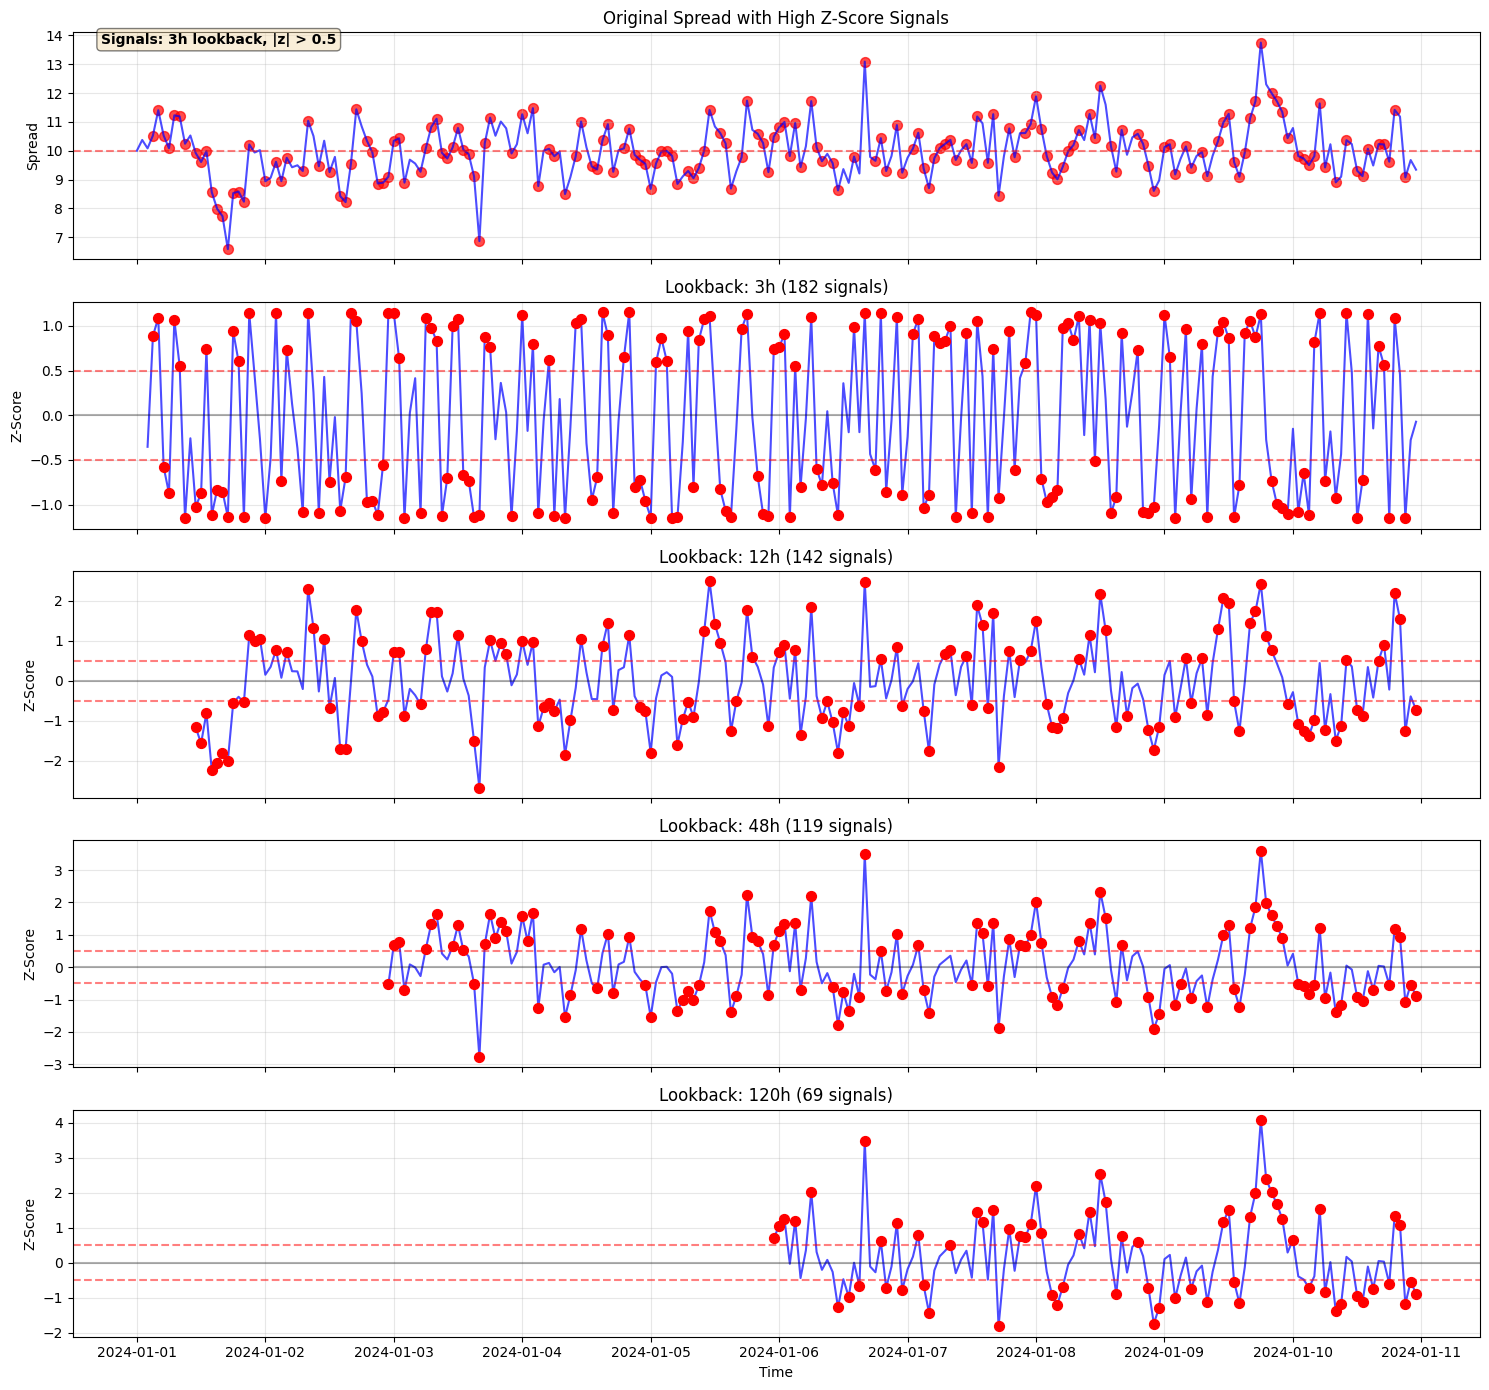

In [197]:
# Calculate z-scores with different lookbacks (adjusted for hourly data)
lookbacks = {
    'very_short': 3,
    'short': 12,
    'medium': 48,
    'long': 120
}

z_scores = {}
for name, lookback in lookbacks.items():
    rolling_mean = spread.rolling(lookback).mean()
    rolling_std = spread.rolling(lookback).std()
    z_scores[name] = (spread - rolling_mean) / rolling_std

# PARAMETERS TO ADJUST
highlight_lookback = 'very_short'  # Change: 'very_short', 'short', 'medium', or 'long'
z_threshold = 0.5              # Change: threshold for "high" z-score

# Plot all
fig, axes = plt.subplots(5, 1, figsize=(15, 14), sharex=True)

# Original spread - marks for ONE lookback only
axes[0].plot(spread, alpha=0.7, color='blue')
axes[0].axhline(y=10, color='r', linestyle='--', alpha=0.5)

# Mark high z-score points for selected lookback only
high_z = np.abs(z_scores[highlight_lookback]) > z_threshold
axes[0].scatter(spread.index[high_z], spread[high_z], 
               s=50, alpha=0.7, color='red')
axes[0].text(0.02, 0.95, 
            f'Signals: {lookbacks[highlight_lookback]}h lookback, |z| > {z_threshold}', 
            transform=axes[0].transAxes, fontweight='bold', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[0].set_ylabel('Spread')
axes[0].set_title('Original Spread with High Z-Score Signals')
axes[0].grid(True, alpha=0.3)

# Z-scores with highlighted signals
for i, (name, lookback) in enumerate(lookbacks.items(), 1):
    axes[i].plot(z_scores[name], color='blue', alpha=0.7)
    axes[i].axhline(y=z_threshold, color='r', linestyle='--', alpha=0.5)
    axes[i].axhline(y=-z_threshold, color='r', linestyle='--', alpha=0.5)
    axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    high_z = np.abs(z_scores[name]) > z_threshold
    axes[i].scatter(z_scores[name].index[high_z], z_scores[name][high_z],
                   color='red', s=50, zorder=5)
    
    axes[i].set_ylabel('Z-Score')
    axes[i].set_title(f'Lookback: {lookback}h ({high_z.sum()} signals)')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()


Probably difficult using purely statistical approaches to select the optimal lookback period for z_score calcaulation. It also depends on the what we classify as extreme.

However, to avoid overfitting risks, at a bare minimum we need to calibrate the lookback period by somehow "locking it" or "hinging it" to the timescale of the mean reversion: so we can think in terms of "units" of mean reversion. This can be done parametrically via half-life estimation or empirically. Some approaches I've seen online: 

- Model dependent 
- 
  - E.g. AR(p) based- see Ernie Chan 
- Zero-crossings
  - Analyse median zero-crossing time    

We will do both ways to see if there is disparity between the two. 

In [209]:
results_buffer_day[1].quantile([0.5, 0.99])
#mean reversion timescale ~ 15 hours 

0.50      948.750000
0.99    10657.783333
Name: origin_time, dtype: float64

In [ ]:
results_buffer_hour[1].quantile([0.5, 0.99])
#mean reversion timescale ~ around 40 minutes 

0.50     39.5
0.99    726.4
Name: origin_time, dtype: float64

In [206]:
def estimate_half_life_ar(spread, maxlag=10):
    """
    Estimate half-life by fitting AR(p) model
    """
    # Convert to integer index (AR model needs sequential integer index)
    spread_int_index = spread.reset_index(drop=True)
    
    # Demean
    demeaned = spread_int_index - spread_int_index.mean()
    
    # Step 1: Select best AR order
    print("Selecting best AR order...")
    selection = ar_select_order(demeaned, maxlag=maxlag, ic='aic')
    best_order = selection.ar_lags
    
    print(f"Best AR order: {len(best_order)} (lags: {best_order})")
    
    # Step 2: Fit AR model
    model = AutoReg(demeaned, lags=best_order, trend='n').fit()
    
    print(f"AIC: {model.aic:.2f}")
    print(f"BIC: {model.bic:.2f}")
    
    # Step 3: Calculate half-life
    ar_params = model.params[1:].values
    lag_to_coef = dict(zip(best_order, ar_params))
    
    if len(ar_params) == 1:
        phi = ar_params[0]
        
        if phi <= 0 or phi >= 1:
            print(f"⚠️  phi = {phi:.3f} (not mean-reverting)")
            half_life = None
        else:
            half_life = -np.log(2) / np.log(phi)
            print(f"✓ phi = {phi:.3f}")
            print(f"✓ Half-life = {half_life:.1f} periods")
    
    else:
        print("Computing impulse response for AR(p)...")
        
        max_steps = 200
        irf = np.zeros(max_steps)
        irf[0] = 1.0
        
        for t in range(1, max_steps):
            for lag, coef in lag_to_coef.items():
                if t >= lag:
                    irf[t] += coef * irf[t - lag]
        
        try:
            half_life_idx = np.argmax(irf < 0.5)
            if half_life_idx == 0:
                half_life = None
                print("⚠️  IRF did not decay to 0.5")
            else:
                half_life = half_life_idx
                print(f"✓ Half-life = {half_life} periods (from IRF)")
        except:
            half_life = None
            print("⚠️  Could not calculate half-life from IRF")
    
    # Diagnostics
    from statsmodels.stats.diagnostic import acorr_ljungbox
    
    residuals = model.resid
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    
    print(f"\nDiagnostics:")
    print(f"  Ljung-Box p-value (lag 10): {lb_test['lb_pvalue'].iloc[-1]:.3f}")
    if lb_test['lb_pvalue'].iloc[-1] > 0.05:
        print(f"  ✓ Residuals appear to be white noise")
    else:
        print(f"  ⚠️  Residuals show autocorrelation (poor fit)")
    
    return {
        'half_life': half_life,
        'ar_order': len(best_order),
        'ar_lags': list(best_order),
        'ar_params': ar_params,
        'aic': model.aic,
        'bic': model.bic,
        'model': model,
        'residuals': residuals
    }

This seems kind of boke, maybe not the best approach. 

In [208]:
estimate_half_life_ar(spreads_by_lookback['hour'].dropna(), maxlag = 40)

Selecting best AR order...
Best AR order: 40 (lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])
AIC: -12762055.82
BIC: -12761568.84
Computing impulse response for AR(p)...
✓ Half-life = 1 periods (from IRF)

Diagnostics:
  Ljung-Box p-value (lag 10): 1.000
  ✓ Residuals appear to be white noise


{'half_life': np.int64(1),
 'ar_order': 40,
 'ar_lags': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40],
 'ar_params': array([ 4.97571501e-02,  2.27708475e-02, -1.98625841e-04, -3.29652981e-04,
         1.37709157e-02, -4.64892341e-03, -1.16093627e-02,  8.45922712e-03,
        -8.41269850e-03, -3.15177577e-03,  1.88089863e-02, -1.54310017e-03,
        -8.33793006e-03,  9.85154587e-03, -7.45265724e-03,  9.79221777e-03,
        -5.54730173e-03, -1.23452286e-02,  1.23955147e-02, -6.17024670e-03,
         2.95055558e-03,  1.66316902e-03,  3.51237752e-03, -7.81459300e-03,
         3.84785607e-04, -9.95164484e-03,  1.12280040e-02, -2.06055862e-03,
         7.79546436e-03, -9.70275436e-03,  5.43680326e-03, -1.28907296e-04,
        -9.01525290e-04,  1.76722831e-05, -1.73224758e-03,  7.60109059e-03,
        -8.58118

Let's hinge it to the median zero crossing time interarrival time. 

* Make a judgment call - likely NOT profitable since median zero-crossing time is almost as long as the rebalancing period. 

# Cross-Validation/Trading Signal Optimisation 

- Intuition - when we are simply COMPARING different strategies against each other, do we necessarily NEED all these bells and whistles? 
- Need **minimum viable portfolio manager** that allows us to compare trading strategies meaningfully 
- As we start getting more refined, then we start to add in more detail 

In [73]:
BETA_LOOKBACK_BY_FREQUENCY = {
    'hour': 1*MINUTES_PER_HOUR*TICKS_PER_MINUTE,
    'day': 1*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE, # 1 day, 
    'week': 7*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE,  # 7 days, 
    'month': 30*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE, #30 days (1 month)
}
MA_UNITS_BY_FREQUENCY = {
    'hour': 30*MINUTES_PER_HOUR*TICKS_PER_MINUTE, #30 minutes 
    'day': 12*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE
}

TRADING_PERIODS_PER_YEAR = TICKS_PER_MINUTE*MINUTES_PER_HOUR*HOURS_IN_DAYS*365

In [109]:
from portfolio_manager.portfolio_manager import PortfolioManager
from trading_strategy import BollingerBandTradeStrategy
from pricing_signals import PricingSignal

In [111]:
temp_df = midprice_df.head(n=200_000)

In [112]:
#Trial run - integration test - initialise as a first pass to see if everything is working )
beta_lookback = BETA_LOOKBACK_GRID['hour'] #hourly lookback 
ma_lookback_unit = 2*MA_UNITS_BY_FREQUENCY['hour'] #hourly moving average 
#Generate trading signal 
signal = PricingSignal(hedge_lookback = beta_lookback, spread_lookback = ma_lookback_unit)
signal_results = signal._generate(y = temp_df['ADA-USDT'], x = temp_df['SOL-USDT'])

<Axes: xlabel='origin_time'>

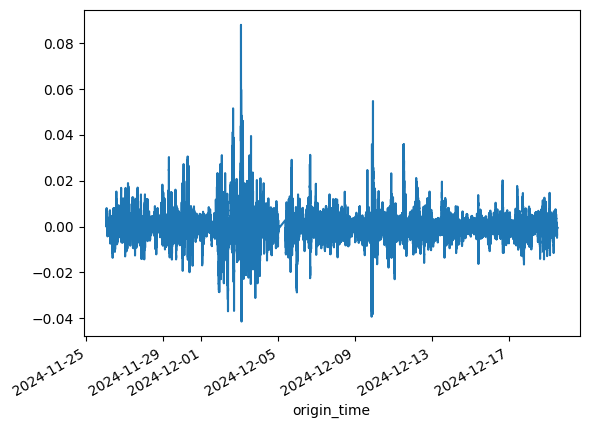

In [113]:
# Check signal 
signal_results['spread'].plot()

In [114]:
#do the nulls work out? 
signal_results['z_score'].isna().sum()
beta_lookback
ma_lookback_unit
beta_lookback + ma_lookback_unit

np.int64(21958)

360

21600

21960

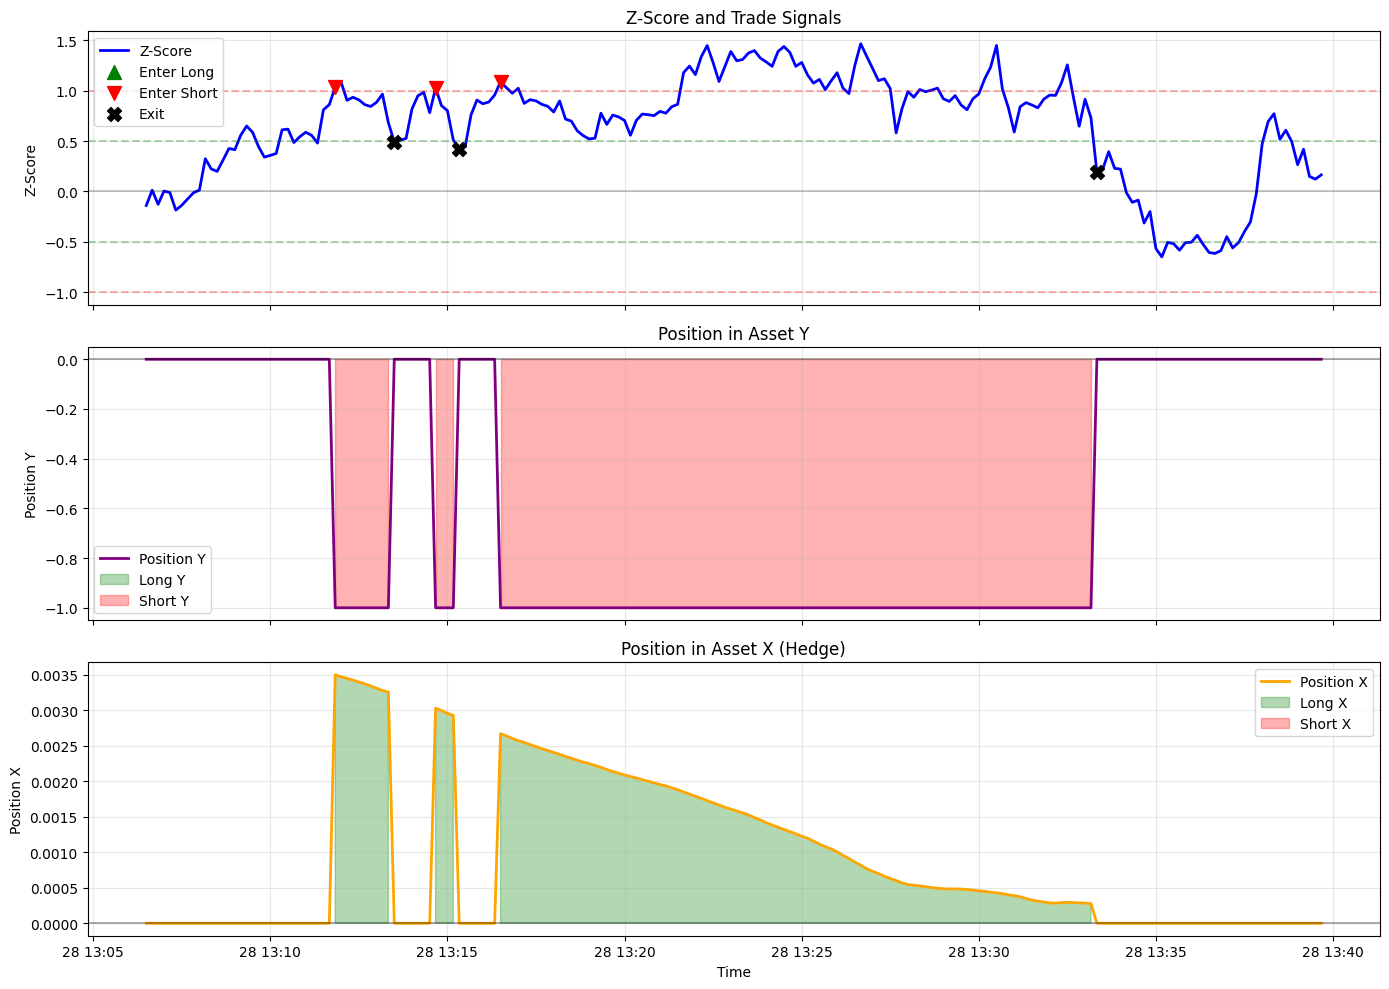

In [115]:
#Generate Trading Actions 
bb = BollingerBandTradeStrategy(entry_threshold=1, exit_threshold = 0.5)
desired_positions = bb.get_positions(z_score = signal_results['z_score'], beta =signal_results['beta'])
#check desired positions by visually plotting a bunch 
bb.plot_positions(beta = signal_results.dropna()['beta'].head(n=200), z_score = signal_results.dropna()['z_score'].head(n=200))

In [116]:
#portfolio manager 
pm = PortfolioManager(idealised = True, initial_capital = 10_000, trading_periods_per_year = trading_periods_per_year)
results = pm.backtest(desired_positions = desired_positions, prices_y = temp_df['ADA-USDT'], prices_x = temp_df['SOL-USDT'])

100%|██████████| 200000/200000 [00:14<00:00, 13409.86it/s]


<Axes: xlabel='origin_time'>

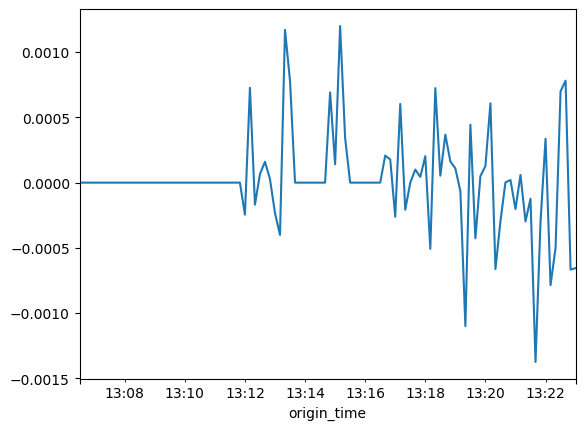

In [117]:
#results - check - is everything consistent with our data inputs? 

#the first three trades should hypotheticlally make money/and be profitable 
idx_non_null = signal_results.dropna().index
results['net_pnl_series'].loc[idx_non_null].head(n=100).plot()

#The PnL is up and down, but that's not inconsistent with our z score signals 

<Axes: xlabel='origin_time'>

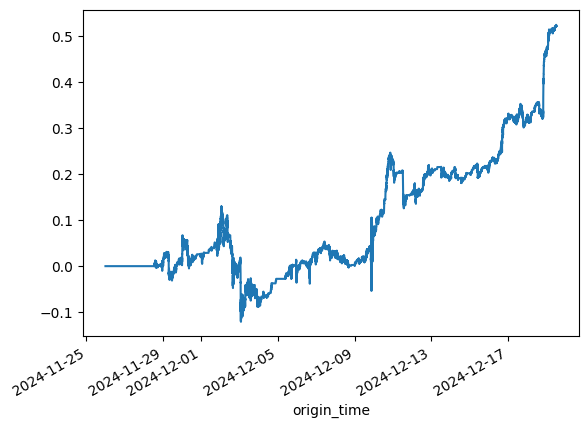

In [178]:
results['net_pnl_series'].cumsum().plot()

In [48]:
#check each of the results 
#Consistent 
results['position_history'].loc[idx_non_null].head(n=100)

,position_y,position_x
origin_time,,
2024-11-28 13:06:40,0.0,0.000000
2024-11-28 13:06:50,0.0,0.000000
2024-11-28 13:07:00,0.0,0.000000
2024-11-28 13:07:10,0.0,0.000000
2024-11-28 13:07:20,0.0,0.000000
2024-11-28 13:07:30,0.0,0.000000
2024-11-28 13:07:40,0.0,0.000000
2024-11-28 13:07:50,0.0,0.000000
2024-11-28 13:08:00,0.0,0.000000


<Axes: xlabel='origin_time'>

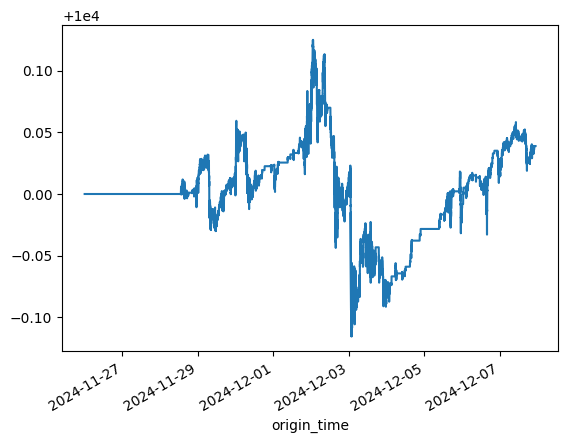

In [49]:
results['equity_curve'].plot()

<Axes: xlabel='origin_time'>

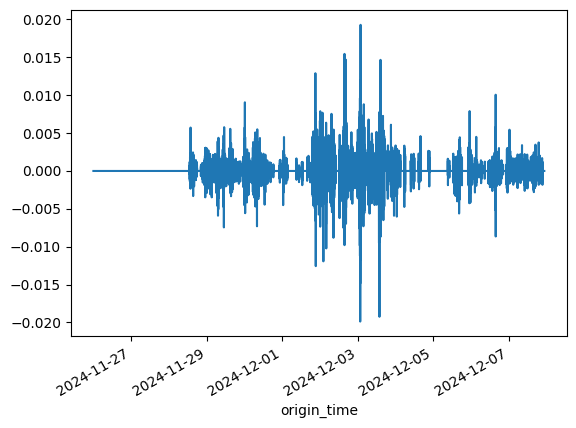

In [51]:
results['net_pnl_series'].plot()

In [53]:
#Are equity curve and Pnl consistent? 
net_pnl = results['net_pnl_series'].loc[idx_non_null]
equity = results['equity_curve'].loc[idx_non_null]

<Axes: xlabel='origin_time'>

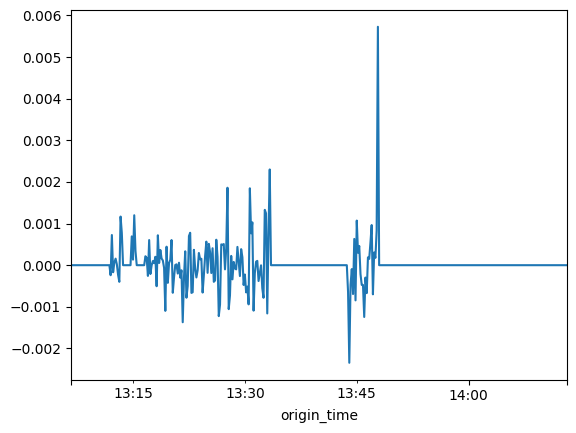

In [67]:
#Visual verification 
net_pnl.head(n=400).plot()

<Axes: xlabel='origin_time'>

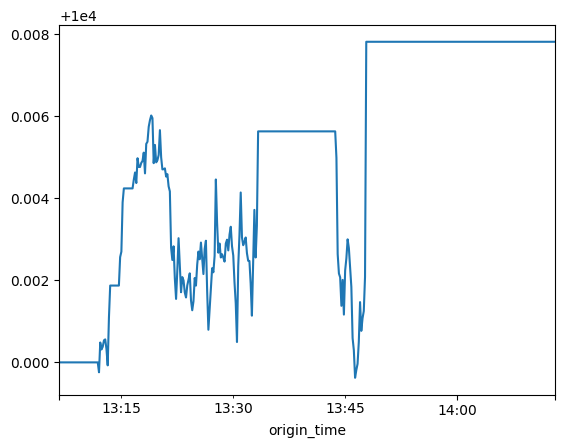

In [66]:
equity.head(n=400).plot()

In [69]:
results['sharpe']

np.float64(1.0611801199503414)

In [169]:
#Implement - cross validation loop/testing for HOURLY signal- first just test out on the first bit of the data 

from collections import defaultdict
entry_threshold = [0.5, 1, 
                   #1.5, 2
                   ]
exit_threshold = [0.25, 0.5, 
                  #0.75, 1
                  ]
lookback_multiple = [0.25, 0.5, 
                     #1, 1.5, 2, 4
                     ]
grid_search = grid_search = list(itertools.product(entry_threshold, exit_threshold, lookback_multiple))
hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour']

results_by_param = {}
temp_df = train_midprice_df.head(n=200_000)

for (entry, exit, lookback_multiple) in grid_search: 
    #Generate signal on rolling OLS with hourly frequency, but with a different SPREAD lookback 
    signal = PricingSignal(hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour'], spread_lookback = int(MA_UNITS_BY_FREQUENCY['hour']*lookback_multiple))
    signal_results = signal._generate(y = temp_df['ADA-USDT'], x = temp_df['SOL-USDT'])
    #initialise an entry 
    results_by_param[(entry, exit, lookback_multiple)] = {'signal': signal_results}
    #desired positions 
    bb = BollingerBandTradeStrategy(entry_threshold=entry, exit_threshold = exit)
    desired_positions = bb.get_positions(z_score = signal_results['z_score'], beta =signal_results['beta'])
    results_by_param[(entry, exit, lookback_multiple)]['desired_positions'] = desired_positions 
    #portfolio manager 
    pm = PortfolioManager(idealised = True, initial_capital = 10_000, trading_periods_per_year = TRADING_PERIODS_PER_YEAR)
    backtest_results = pm.backtest(desired_positions = desired_positions, prices_y = temp_df['ADA-USDT'], prices_x = temp_df['SOL-USDT'])
    results_by_param[(entry, exit, lookback_multiple)]['backtest'] = backtest_results

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\

KeyboardInterrupt: 

In [128]:
#print and visualise 
#get the one with the highest sharpe ratio 
sharpe_ratios = {k: results_by_param[k]['backtest']['sharpe'] for k in results_by_param.keys()}
max(sharpe_ratios, key = sharpe_ratios.get)
sharpe_ratios

(0.5, 0.5, 0.25)

{(0.5, 0.25, 0.25): np.float64(12.292373101027996),
 (0.5, 0.25, 0.5): np.float64(15.238603934707802),
 (0.5, 0.5, 0.25): np.float64(22.9755785447805),
 (0.5, 0.5, 0.5): np.float64(22.651190246109653),
 (1, 0.25, 0.25): np.float64(7.332320056324562),
 (1, 0.25, 0.5): np.float64(6.550619770039136),
 (1, 0.5, 0.25): np.float64(11.670926080379164),
 (1, 0.5, 0.5): np.float64(8.980060535173664)}

In [148]:
buy_hold_position

2024-11-26 00:00:00    1
2024-11-26 00:00:10    1
2024-11-26 00:00:20    1
2024-11-26 00:00:30    1
2024-11-26 00:00:40    1
                      ..
2024-12-19 03:32:30    1
2024-12-19 03:32:40    1
2024-12-19 03:32:50    1
2024-12-19 03:33:00    1
2024-12-19 03:33:10    1
Freq: 10s, Length: 200000, dtype: int64

In [149]:
#implement a baseline strategy to compare against - e.g. Bitcoin buy and hold strategy over same period 
from portfolio_manager.baseline_trading_strategy import BuyHoldStrategy 
bh = BuyHoldStrategy()
buy_hold_position = bh._calculate_desired_positions(num_units = 1, index = temp_df.index)
#Cast into the same shape - for now 
buy_hold_position = pd.DataFrame({'position_y': buy_hold_position, 'position_x': pd.Series(0, index = temp_df.index)})
pm = PortfolioManager(idealised = True, initial_capital = 10_000, trading_periods_per_year = TRADING_PERIODS_PER_YEAR)
results_buy_hold = pm.backtest(desired_positions = buy_hold_position, prices_y = temp_df['BTC-USDT'].ffill(), prices_x = pd.Series(0, index = temp_df.index))

100%|██████████| 200000/200000 [00:15<00:00, 12720.61it/s]


In [150]:
results_buy_hold['sharpe']

np.float64(2.542550899088409)

<Axes: >

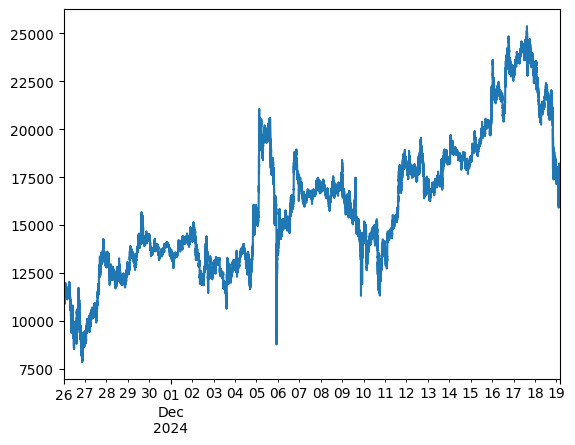

In [153]:
results_buy_hold['equity_curve'].plot()

<Axes: >

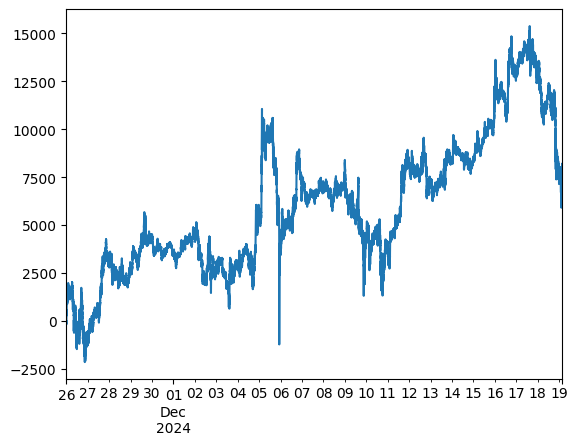

In [155]:
#look at cumulative profits 
#seems to be quite profitable 
results_buy_hold['net_pnl_series'].cumsum().plot()

# Part 2 - Use bid/ask spreads and lagged execution for more reliability 

In [194]:
train_df

,received_time,bid_0_price,ask_0_price,bid_0_size,ask_0_size,symbol,exchange,mid_price
origin_time,,,,,,,,
2024-11-26 00:00:00,2024-11-26 00:00:09.917025536,92935.90,92935.91,2.55032,0.36348,BTC-USDT,BINANCE,92935.905
2024-11-26 00:00:10,2024-11-26 00:00:19.816896512,93154.46,93154.47,1.00850,1.57237,BTC-USDT,BINANCE,93154.465
2024-11-26 00:00:20,2024-11-26 00:00:29.516736256,93034.63,93034.64,0.00271,3.10595,BTC-USDT,BINANCE,93034.635
2024-11-26 00:00:30,2024-11-26 00:00:39.916487680,93071.42,93071.43,1.34965,0.00041,BTC-USDT,BINANCE,93071.425
2024-11-26 00:00:40,2024-11-26 00:00:49.632005376,93028.00,93028.75,0.00540,0.00265,BTC-USDT,BINANCE,93028.375
...,...,...,...,...,...,...,...,...
2025-08-31 23:59:10,2025-08-31 23:59:15.330409728,108377.50,108377.51,0.96821,0.02248,WBTC-USDT,BINANCE,108377.505
2025-08-31 23:59:20,2025-08-31 23:59:20.730221568,108377.50,108377.51,0.99736,0.02248,WBTC-USDT,BINANCE,108377.505
2025-08-31 23:59:30,2025-08-31 23:59:35.230087680,108377.50,108377.51,0.97176,0.02248,WBTC-USDT,BINANCE,108377.505


In [191]:
next_df = train_midprice_df.iloc[200_000:400_000].ffill()
entry = 0.5 
exit = 0.5 
lookback_multiple = 0.25

In [193]:
#run - rolling OLS, with an hourly frequency 
signal = PricingSignal(hedge_lookback = BETA_LOOKBACK_BY_FREQUENCY['hour'], spread_lookback = int(MA_UNITS_BY_FREQUENCY['hour']*lookback_multiple))
signal_results = signal._generate(y = next_df['ADA-USDT'], x = next_df['SOL-USDT'])
#desired positions 
bb = BollingerBandTradeStrategy(entry_threshold=entry, exit_threshold = exit)
desired_positions = bb.get_positions(z_score = signal_results['z_score'], beta =signal_results['beta'])

In [ ]:
#portfolio manager 
pm = PortfolioManager(idealised = True, initial_capital = 10_000, trading_periods_per_year = TRADING_PERIODS_PER_YEAR)
backtest_results = pm.backtest(desired_positions = desired_positions, prices_y = next_df['ADA-USDT'], prices_x = next_df['SOL-USDT'])

In [172]:
buy_hold_position = bh._calculate_desired_positions(num_units = 1, index = next_df.index)
#Cast into the same shape - for now 
buy_hold_position = pd.DataFrame({'position_y': buy_hold_position, 'position_x': pd.Series(0, index = next_df.index)})
pm = PortfolioManager(idealised = True, initial_capital = 10_000, trading_periods_per_year = TRADING_PERIODS_PER_YEAR)
results_buy_hold = pm.backtest(desired_positions = buy_hold_position, prices_y = next_df['BTC-USDT'].ffill(), prices_x = pd.Series(0, index = next_df.index))

100%|██████████| 200000/200000 [00:15<00:00, 12831.09it/s]


In [173]:
backtest_results['sharpe']

np.float64(22.043982652724598)

In [174]:
#too much variability - difficult to compare to baseline due to variability in trading/testing periods --> need to do a better analysis 
results_buy_hold['sharpe']

np.float64(-2.280658774699392)

<Axes: >

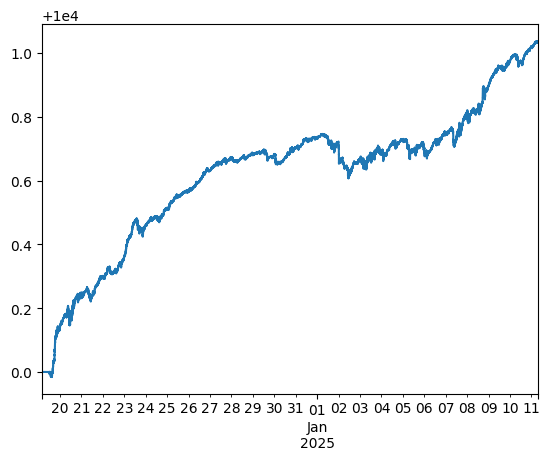

In [176]:
backtest_results['equity_curve'].plot()

# Next Steps 

Let's try evaluating/honing our trading strategy with more realistic trading constraints. 